In [2]:
import sys
import subprocess
import os

def install_packages():
    """Install required packages"""
    packages = [
        'ultralytics',
        'scikit-learn',
        'matplotlib',
        'opencv-python',
        'pyyaml'
    ]
    
    for package in packages:
        try:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])
            print(f"✓ {package} installed successfully")
        except subprocess.CalledProcessError:
            print(f"✗ Failed to install {package}")
install_packages()            

✓ ultralytics installed successfully
✓ scikit-learn installed successfully
✓ matplotlib installed successfully
✓ opencv-python installed successfully
✓ pyyaml installed successfully


In [3]:
import glob
import xml.etree.ElementTree as ET
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import yaml
import cv2
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import patches
import zipfile
import urllib.request
from pathlib import Path

In [4]:
WORK_DIR = Path.cwd()
DATASET_DIR = WORK_DIR / "dataset"
YOLO_DATASET_DIR = WORK_DIR / "yolo_dataset"
MODEL_OUTPUT_DIR = WORK_DIR / "trained_models"

print(f"Working directory: {WORK_DIR}")
print(f"Dataset directory: {DATASET_DIR}")
print(f"YOLO dataset directory: {YOLO_DATASET_DIR}")
print(f"Model output directory: {MODEL_OUTPUT_DIR}")


Working directory: /Users/sriharshitha/Documents/vscode/chart
Dataset directory: /Users/sriharshitha/Documents/vscode/chart/dataset
YOLO dataset directory: /Users/sriharshitha/Documents/vscode/chart/yolo_dataset
Model output directory: /Users/sriharshitha/Documents/vscode/chart/trained_models


In [5]:
def setup_directories():
    """Create necessary directories"""
    directories = [
        DATASET_DIR,
        YOLO_DATASET_DIR,
        MODEL_OUTPUT_DIR,
        YOLO_DATASET_DIR / "images" / "train",
        YOLO_DATASET_DIR / "images" / "val",
        YOLO_DATASET_DIR / "labels" / "train",
        YOLO_DATASET_DIR / "labels" / "val"
    ]
    
    for directory in directories:
        directory.mkdir(parents=True, exist_ok=True)
        print(f"✓ Created directory: {directory}")

setup_directories()

✓ Created directory: /Users/sriharshitha/Documents/vscode/chart/dataset
✓ Created directory: /Users/sriharshitha/Documents/vscode/chart/yolo_dataset
✓ Created directory: /Users/sriharshitha/Documents/vscode/chart/trained_models
✓ Created directory: /Users/sriharshitha/Documents/vscode/chart/yolo_dataset/images/train
✓ Created directory: /Users/sriharshitha/Documents/vscode/chart/yolo_dataset/images/val
✓ Created directory: /Users/sriharshitha/Documents/vscode/chart/yolo_dataset/labels/train
✓ Created directory: /Users/sriharshitha/Documents/vscode/chart/yolo_dataset/labels/val


In [6]:
class_names = [
    'area', 'heatmap', 'horizontal_bar', 'horizontal_interval', 'line',
    'manhattan', 'map', 'pie', 'scatter', 'scatter-line', 'surface',
    'venn', 'vertical_bar', 'vertical_box', 'vertical_interval'
]

print(f"Number of chart classes: {len(class_names)}")
print(f"Classes: {class_names}")

Number of chart classes: 15
Classes: ['area', 'heatmap', 'horizontal_bar', 'horizontal_interval', 'line', 'manhattan', 'map', 'pie', 'scatter', 'scatter-line', 'surface', 'venn', 'vertical_bar', 'vertical_box', 'vertical_interval']


In [7]:
def download_dataset():
    """Download and extract the ChartInfo dataset"""
    dataset_url = "https://www.dropbox.com/scl/fi/2c2yjerpiv5778j0xyi4u/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1.0.zip?rlkey=hyrmt6wyac4s1zt5vm55htc70&dl=1"
    zip_path = WORK_DIR / "chartinfo_dataset.zip"
    
    if not (DATASET_DIR / "ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1.0").exists():
        print("Downloading dataset...")
        try:
            urllib.request.urlretrieve(dataset_url, zip_path)
            print("✓ Dataset downloaded successfully")
            
            print("Extracting dataset...")
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(DATASET_DIR)
            print("✓ Dataset extracted successfully")
            
            # Clean up zip file
            zip_path.unlink()
            print("✓ Zip file cleaned up")
            
        except Exception as e:
            print(f"✗ Error downloading dataset: {e}")
            print("Please download the dataset manually and place it in the dataset folder")
    else:
        print("✓ Dataset already exists")

# Uncomment to download dataset
download_dataset()

✓ Dataset downloaded successfully
Extracting dataset...
✓ Dataset extracted successfully
✓ Zip file cleaned up


In [8]:
def convert_xml_to_yolo(xml_file, output_dir, class_mapping):
    """Convert XML annotation to YOLO format"""
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()

        # Extract image dimensions from the PanelTreeNode
        panel_tree_node = root.find('.//PanelTreeNode')
        if panel_tree_node is None:
            print(f"Warning: No PanelTreeNode found in {xml_file}")
            return None

        x1 = float(panel_tree_node.find('X1').text)
        y1 = float(panel_tree_node.find('Y1').text)
        x2 = float(panel_tree_node.find('X2').text)
        y2 = float(panel_tree_node.find('Y2').text)
        img_width = x2
        img_height = y2

        if img_width == 0 or img_height == 0:
            print(f"Warning: Invalid dimensions in {xml_file}")
            return None

        # Extract chart type
        chart_info = root.find('.//ChartInfo/Type')
        if chart_info is None:
            print(f"Warning: No ChartInfo/Type found in {xml_file}")
            return None

        chart_type = chart_info.text

        # Check if the chart type is in our class mapping
        if chart_type not in class_mapping:
            print(f"Warning: Unknown chart type {chart_type} in {xml_file}")
            return None

        class_id = class_mapping[chart_type]

        # Calculate YOLO format coordinates
        x_center = (x1 + x2) / 2 / img_width
        y_center = (y1 + y2) / 2 / img_height
        width = (x2 - x1) / img_width
        height = (y2 - y1) / img_height

        # Create YOLO format annotation
        yolo_annotation = f"{class_id} {x_center} {y_center} {width} {height}\n"

        # Get the image filename without extension
        img_filename = Path(xml_file).stem

        # Write to output file
        output_file = output_dir / f"{img_filename}.txt"
        with open(output_file, 'w') as f:
            f.write(yolo_annotation)

        return img_filename

    except Exception as e:
        print(f"Error processing {xml_file}: {str(e)}")
        return None



In [9]:
def process_dataset():
    """Process the dataset and convert to YOLO format"""
    dataset_path = DATASET_DIR / "ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1.0"
    
    if not dataset_path.exists():
        print(f"Dataset not found at {dataset_path}")
        print("Please ensure the dataset is downloaded and extracted")
        return None
    
    # Create class mapping
    class_mapping = {class_name: idx for idx, class_name in enumerate(class_names)}

    # Write class names to file
    classes_file = YOLO_DATASET_DIR / 'classes.txt'
    with open(classes_file, 'w') as f:
        for class_name in class_names:
            f.write(f"{class_name}\n")

    # Process each chart type
    all_files = []
    labels_temp_dir = YOLO_DATASET_DIR / "labels_temp"
    labels_temp_dir.mkdir(exist_ok=True)
    
    for chart_type in class_names:
        xml_dir = dataset_path / 'annotations_XML' / chart_type
        img_dir = dataset_path / 'images' / chart_type

        if not xml_dir.exists():
            print(f"Warning: Directory {xml_dir} does not exist")
            continue

        # Get all XML files for this chart type
        xml_files = list(xml_dir.glob('*.xml'))
        print(f"Found {len(xml_files)} XML files for {chart_type}")

        # Process each XML file
        for xml_file in xml_files:
            img_filename = convert_xml_to_yolo(xml_file, labels_temp_dir, class_mapping)
            if img_filename:
                all_files.append((chart_type, img_filename))

    print(f"Total files processed: {len(all_files)}")

    # Split into train and validation sets
    train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)

    # Copy images and labels to train and val directories
    for files, subset in [(train_files, 'train'), (val_files, 'val')]:
        for chart_type, filename in files:
            # Copy the image (try both jpg and png)
            src_img = dataset_path / 'images' / chart_type / f"{filename}.jpg"
            if not src_img.exists():
                src_img = dataset_path / 'images' / chart_type / f"{filename}.png"

            if src_img.exists():
                dst_img = YOLO_DATASET_DIR / 'images' / subset / f"{filename}{src_img.suffix}"
                shutil.copy(src_img, dst_img)
            else:
                print(f"Warning: Image for {filename} not found")
                continue

            # Copy the label
            src_label = labels_temp_dir / f"{filename}.txt"
            if src_label.exists():
                dst_label = YOLO_DATASET_DIR / 'labels' / subset / f"{filename}.txt"
                shutil.copy(src_label, dst_label)

    # Clean up temporary labels directory
    shutil.rmtree(labels_temp_dir)

    # Create YAML configuration file for YOLO
    yaml_content = {
        'path': str(YOLO_DATASET_DIR),
        'train': 'images/train',
        'val': 'images/val',
        'nc': len(class_names),
        'names': class_names
    }

    yaml_file = YOLO_DATASET_DIR / 'dataset.yaml'
    with open(yaml_file, 'w') as f:
        yaml.dump(yaml_content, f, default_flow_style=False)

    print(f"Dataset prepared for YOLO training.")
    print(f"Train set: {len(train_files)}, Validation set: {len(val_files)}")
    print(f"YAML config saved to: {yaml_file}")
    
    return str(yaml_file)

# Run dataset processing
yaml_config = process_dataset()


Found 172 XML files for area
Found 197 XML files for heatmap
Found 787 XML files for horizontal_bar
Found 156 XML files for horizontal_interval
Found 10556 XML files for line
Found 176 XML files for manhattan
Found 533 XML files for map
Found 242 XML files for pie
Found 1350 XML files for scatter
Found 1818 XML files for scatter-line
Found 155 XML files for surface
Found 75 XML files for venn
Found 5454 XML files for vertical_bar
Found 763 XML files for vertical_box
Found 489 XML files for vertical_interval
Total files processed: 15274
Dataset prepared for YOLO training.
Train set: 12219, Validation set: 3055
YAML config saved to: /Users/sriharshitha/Documents/vscode/chart/yolo_dataset/dataset.yaml


Displaying sample images...


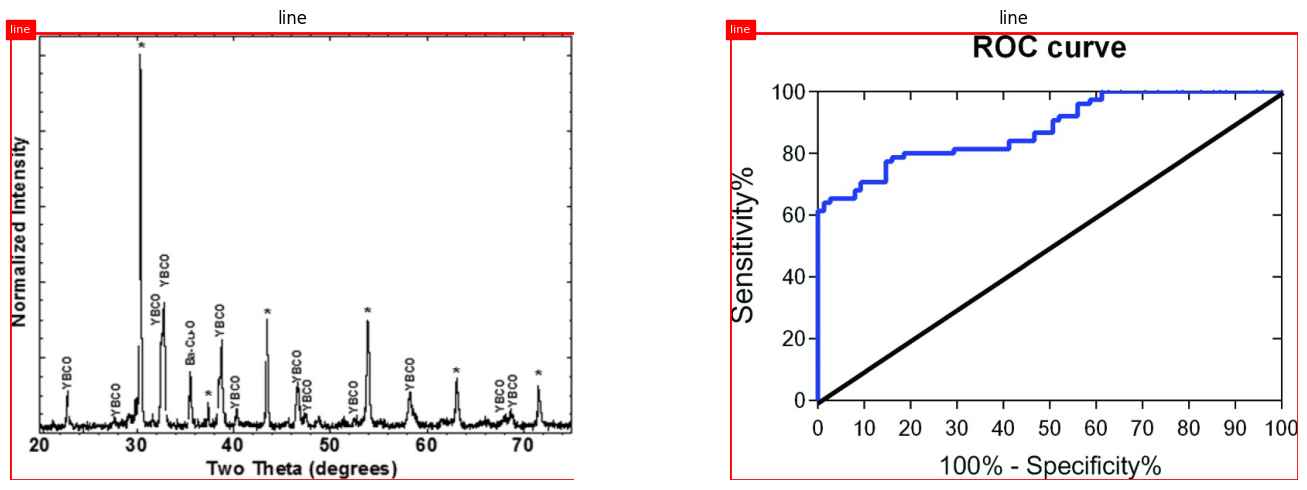

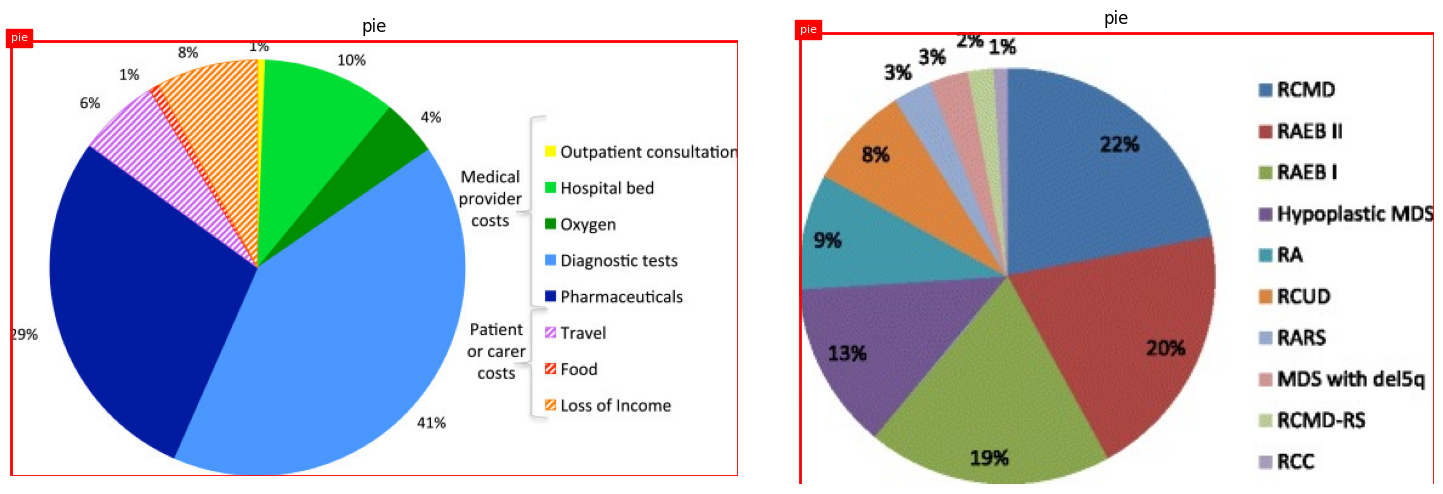

In [10]:
def display_sample_with_annotations(class_name, num_samples=3):
    """Display sample images with annotations for visualization"""
    label_dir = YOLO_DATASET_DIR / 'labels' / 'train'
    image_dir = YOLO_DATASET_DIR / 'images' / 'train'

    # Get image files
    image_files = list(image_dir.iterdir())

    # Load class names
    classes_file = YOLO_DATASET_DIR / 'classes.txt'
    with open(classes_file, 'r') as f:
        classes = [line.strip() for line in f.readlines()]

    target_class_idx = classes.index(class_name)

    # Find images with the target class
    samples = []
    for img_file in image_files:
        if not img_file.suffix.lower() in ['.jpg', '.png', '.jpeg']:
            continue
            
        base_name = img_file.stem
        label_file = label_dir / f"{base_name}.txt"

        if label_file.exists():
            with open(label_file, 'r') as f:
                for line in f:
                    class_id = int(line.split()[0])
                    if class_id == target_class_idx:
                        samples.append((img_file, label_file))
                        break

        if len(samples) >= num_samples:
            break

    # Display samples
    if not samples:
        print(f"No samples found for class: {class_name}")
        return
        
    fig, axes = plt.subplots(1, min(num_samples, len(samples)), figsize=(15, 5))
    if len(samples) == 1:
        axes = [axes]
    elif len(samples) < num_samples:
        axes = axes[:len(samples)]

    for i, (img_file, label_file) in enumerate(samples[:num_samples]):
        img = cv2.imread(str(img_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        h, w, _ = img.shape

        axes[i].imshow(img)
        axes[i].set_title(f"{class_name}")

        # Load and draw annotations
        with open(label_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                class_id = int(parts[0])
                x_center = float(parts[1]) * w
                y_center = float(parts[2]) * h
                width = float(parts[3]) * w
                height = float(parts[4]) * h

                # Convert to corner coordinates
                x1 = x_center - width / 2
                y1 = y_center - height / 2

                rect = patches.Rectangle((x1, y1), width, height,
                                       linewidth=2, edgecolor='r', facecolor='none')
                axes[i].add_patch(rect)
                axes[i].text(x1, y1, f"{classes[class_id]}",
                           color='white', backgroundcolor='red', fontsize=8)

        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Display sample images
if yaml_config:
    print("Displaying sample images...")
    for chart_type in ['line', 'pie', 'scatter'][:2]:
        display_sample_with_annotations(chart_type, 2)


In [11]:
def train_model(yaml_file, model_size='m', epochs=50, batch_size=16, img_size=640):
    """Train the YOLO model with optimized parameters"""
    try:
        from ultralytics import YOLO
    except ImportError:
        print("Ultralytics not installed. Installing now...")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'ultralytics'])
        from ultralytics import YOLO

    # Load a pretrained model
    model = YOLO(f'yolov8{model_size}.pt')

    # Train the model with optimized parameters
    results = model.train(
        data=yaml_file,
        epochs=epochs,
        batch=batch_size,
        imgsz=img_size,
        patience=20,
        save=True,
        project=str(MODEL_OUTPUT_DIR),
        name='chart_detection_optimized',
        device=0 if 'cuda' in str(model.device) else 'cpu',
        optimizer='AdamW',
        lr0=0.01,
        mosaic=1.0,
        mixup=0.1,
        copy_paste=0.3,
        val=True,
        plots=True
    )

    return model, results

# Train the model (uncomment to run training)
if yaml_config:
    print("Starting model training...")
    model, training_results = train_model(yaml_config, model_size='n', epochs=35)  # Quick test
    print("Training completed!")


Starting model training...


/Users/sriharshitha/Documents/vscode/chart/env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6.25M/6.25M [00:00<00:00, 14.9MB/s]


New https://pypi.org/project/ultralytics/8.3.161 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.96 🚀 Python-3.9.6 torch-2.6.0 CPU (Apple M4 Pro)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/Users/sriharshitha/Documents/vscode/chart/yolo_dataset/dataset.yaml, epochs=35, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=/Users/sriharshitha/Documents/vscode/chart/trained_models, name=chart_detection_optimized, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment

train: Scanning /Users/sriharshitha/Documents/vscode/chart/yolo_dataset/labels/train... 12219 images, 0 backgrounds, 0 corrupt: 100%|██████████| 12219/12219 [00:03<0


train: New cache created: /Users/sriharshitha/Documents/vscode/chart/yolo_dataset/labels/train.cache


val: Scanning /Users/sriharshitha/Documents/vscode/chart/yolo_dataset/labels/val... 3055 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3055/3055 [00:00<00:00, 3

val: New cache created: /Users/sriharshitha/Documents/vscode/chart/yolo_dataset/labels/val.cache


Plotting labels to /Users/sriharshitha/Documents/vscode/chart/trained_models/chart_detection_optimized/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /Users/sriharshitha/Documents/vscode/chart/trained_models/chart_detection_optimized
Starting training for 35 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/35         0G     0.7482      1.671      1.353         50        640:  28%|██▊       | 211/764 [21:33<56:30,  6.13s/it]  


KeyboardInterrupt: 

In [ ]:
def run_inference_on_samples(model_path, num_samples=5):
    """Run inference on sample images and display results"""
    try:
        from ultralytics import YOLO
    except ImportError:
        print("Ultralytics not available")
        return

    # Load the model
    model = YOLO(model_path)

    # Get sample images
    image_dir = YOLO_DATASET_DIR / 'images' / 'val'
    image_files = list(image_dir.glob('*'))[:num_samples]

    # Load class names
    classes_file = YOLO_DATASET_DIR / 'classes.txt'
    with open(classes_file, 'r') as f:
        classes = [line.strip() for line in f.readlines()]

    # Run inference on each image
    for img_file in image_files:
        if not img_file.suffix.lower() in ['.jpg', '.png', '.jpeg']:
            continue
            
        results = model.predict(source=str(img_file), conf=0.25)

        # Display results
        for r in results:
            img = r.orig_img

            # Plot detections
            fig, ax = plt.subplots(figsize=(12, 8))
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

            # Get boxes and labels
            if len(r.boxes) > 0:
                boxes = r.boxes.xyxy.cpu().numpy()
                cls_indices = r.boxes.cls.cpu().numpy().astype(int)
                confidences = r.boxes.conf.cpu().numpy()

                # Draw each detection
                for box, cls_idx, conf in zip(boxes, cls_indices, confidences):
                    x1, y1, x2, y2 = box
                    class_name = classes[cls_idx]

                    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                           linewidth=3, edgecolor='red', facecolor='none')
                    ax.add_patch(rect)
                    ax.text(x1, y1-10, f"{class_name} {conf:.2f}",
                          bbox=dict(facecolor='red', alpha=0.7), fontsize=12, color='white')

            ax.set_title(f"Chart Detection: {img_file.name}", fontsize=14)
            plt.axis('off')
            plt.tight_layout()
            plt.show()


In [ ]:
def detect_charts(model_path, image_path, conf_threshold=0.25):
    """Run inference on a new image"""
    try:
        from ultralytics import YOLO
    except ImportError:
        print("Ultralytics not available")
        return None

    # Load the model
    model = YOLO(model_path)

    # Run inference
    results = model.predict(source=image_path, conf=conf_threshold, save=True)

    # Display results
    for r in results:
        img = r.orig_img

        # Plot detections
        plt.figure(figsize=(15, 10))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        # Get boxes and labels
        if len(r.boxes) > 0:
            boxes = r.boxes.xyxy.cpu().numpy()
            cls_indices = r.boxes.cls.cpu().numpy().astype(int)
            confidences = r.boxes.conf.cpu().numpy()

            # Draw each detection
            for box, cls_idx, conf in zip(boxes, cls_indices, confidences):
                x1, y1, x2, y2 = box
                class_name = class_names[cls_idx]

                rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                       linewidth=3, edgecolor='red', facecolor='none')
                plt.gca().add_patch(rect)
                plt.text(x1, y1-10, f"{class_name} {conf:.2f}",
                      bbox=dict(facecolor='red', alpha=0.7), fontsize=14, color='white')

        plt.title("Chart Detection Results", fontsize=16)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    return results


In [ ]:
def evaluate_model_performance(model_path):
    """Comprehensive model evaluation"""
    try:
        from ultralytics import YOLO
    except ImportError:
        print("Ultralytics not available")
        return

    # Load the model
    model = YOLO(model_path)

    # Load validation data paths
    val_image_dir = YOLO_DATASET_DIR / 'images' / 'val'
    val_label_dir = YOLO_DATASET_DIR / 'labels' / 'val'

    # Load class names
    classes_file = YOLO_DATASET_DIR / 'classes.txt'
    with open(classes_file, 'r') as f:
        class_names_eval = [line.strip() for line in f.readlines()]

    # Store actual and predicted classes
    all_true_classes = []
    all_pred_classes = []
    detection_stats = {'total_images': 0, 'images_with_detections': 0, 'total_detections': 0}

    # Process each image in validation set
    val_images = [f for f in val_image_dir.iterdir() if f.suffix.lower() in ['.jpg', '.png', '.jpeg']]
    detection_stats['total_images'] = len(val_images)

    for img_file in val_images:
        base_name = img_file.stem
        label_path = val_label_dir / f"{base_name}.txt"

        # Get true labels
        if label_path.exists():
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    true_class = int(parts[0])
                    all_true_classes.append(true_class)

        # Get predictions
        results = model.predict(source=str(img_file), conf=0.25, verbose=False)

        for r in results:
            if len(r.boxes) > 0:
                detection_stats['images_with_detections'] += 1
                # Get predicted classes
                pred_classes = r.boxes.cls.cpu().numpy().astype(int)
                detection_stats['total_detections'] += len(pred_classes)
                all_pred_classes.extend(pred_classes)

    # Print detection statistics
    print("=== Detection Statistics ===")
    print(f"Total validation images: {detection_stats['total_images']}")
    print(f"Images with detections: {detection_stats['images_with_detections']}")
    print(f"Detection rate: {detection_stats['images_with_detections']/detection_stats['total_images']*100:.2f}%")
    print(f"Total detections: {detection_stats['total_detections']}")
    print(f"Average detections per image: {detection_stats['total_detections']/detection_stats['total_images']:.2f}")

    # Generate confusion matrix if we have predictions
    if len(all_true_classes) > 0 and len(all_pred_classes) > 0:
        unique_true = sorted(set(all_true_classes))
        unique_pred = sorted(set(all_pred_classes))
        all_classes = sorted(set(unique_true + unique_pred))

        present_class_names = [class_names_eval[i] for i in all_classes if i < len(class_names_eval)]

        print(f"\nClasses in evaluation: {present_class_names}")

        # Balance the lists
        min_len = min(len(all_true_classes), len(all_pred_classes))
        all_true_classes = all_true_classes[:min_len]
        all_pred_classes = all_pred_classes[:min_len]

        # Generate confusion matrix
        cm = confusion_matrix(all_true_classes, all_pred_classes, labels=all_classes)

        # Plot confusion matrix
        plt.figure(figsize=(12, 10))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix - Chart Detection', fontsize=16)
        plt.colorbar()

        tick_marks = np.arange(len(present_class_names))
        plt.xticks(tick_marks, present_class_names, rotation=45, ha='right')
        plt.yticks(tick_marks, present_class_names)

        # Add text annotations
        thresh = cm.max() / 2.
        for i, j in np.ndindex(cm.shape):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

        plt.xlabel('Predicted', fontsize=14)
        plt.ylabel('True', fontsize=14)
        plt.tight_layout()
        plt.show()

        # Generate classification report
        try:
            report = classification_report(
                all_true_classes,
                all_pred_classes,
                labels=all_classes,
                target_names=present_class_names,
                zero_division=0
            )
            print("\n=== Classification Report ===")
            print(report)
        except ValueError as e:
            print(f"Error generating classification report: {e}")


In [ ]:
if model_path is None:
        # Try to find the trained model
        possible_path = MODEL_OUTPUT_DIR / 'chart_detection_optimized' / 'weights' / 'best.pt'
        if possible_path.exists():
            model_path = str(possible_path)
        else:
            print("No trained model found. Please train the model first.")
            return
    
    print(f"Using model: {model_path}")
    
    # Run inference on validation samples
    print("\n=== Sample Predictions ===")
    run_inference_on_samples(model_path, num_samples=2)
    
    # Show model performance
    print("\n=== Model Performance ===")
    evaluate_model_performance(model_path)

In [ ]:
def detect_chart_in_image(image_path, model_path=None, conf_threshold=0.25):
    """Convenient function to detect charts in a single image"""
    if model_path is None:
        # Try to find the trained model
        possible_path = MODEL_OUTPUT_DIR / 'chart_detection_optimized' / 'weights' / 'best.pt'
        if possible_path.exists():
            model_path = str(possible_path)
        else:
            print("No trained model found. Please train the model first.")
            return None
    
    print(f"Detecting charts in: {image_path}")
    print(f"Using model: {model_path}")
    
    results = detect_charts(model_path, image_path, conf_threshold)
    return results